In [1]:
# Example of LSTM to learn a sequence
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation
from keras.layers import LSTM
import matplotlib.pyplot as plt
import matplotlib
import time
import pandas as pd
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:
sin = 'sinwave.csv'
df = pd.read_csv(sin,header=0,squeeze=True)
# create X/y pairs
df = concat([df.shift(1), df], axis=1)
df.dropna(inplace=True)
# convert to LSTM friendly format
values = df.values
# split data into train and test
train_size = int(len(df) * 0.67)
test_size = len(df) - train_size
X,Y = values[:,0],values[:,1]
# train, test = series[0:train_size], series[train_size:len(series)]
trainX, trainY = X[0:train_size], Y[0:train_size]
testX, testY = X[-test_size:len(values)], Y[-test_size:len(values)][:-90]
trainX,testX = trainX.reshape(len(trainX), 1, 1), testX[:-90].reshape(len(testX[:-90]), 1, 1)
shifttestY = testY[:-10]
shifttestX = testX[:-10]

In [36]:
# plt.figure()
# # testX = testX[:-93,0].reshape(len(testX[:-93,0]), 1, 1)
# # testY = testY[:-93]
# plt.plot(testY)
# print len(testY)
# plt.plot(shifttestY)
# print len(shifttestY)
# plt.show()
shifttestX.shape

(1550, 1, 1)

In [4]:
# reader for jakobs
seq_len = 1
def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'rb').read()
    data = f.decode().split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data
# X_train, y_train, X_test, y_test = load_data('sp500.csv', seq_len, True)
trainX, trainY, testX, testY = load_data('sp500.csv', seq_len, True)
shifttestY = testY[:-10]

In [ ]:
# create sequence
length = 1000
sequence = [i/float(length) for i in range(length)]
# print(sequence)
# create X/y pairs
df = DataFrame(sequence)
df = concat([df.shift(1), df], axis=1)
df.dropna(inplace=True)
# convert to LSTM friendly format
values = df.values
X, y = values[:, 0], values[:, 1]
trainX = X.reshape(len(X), 1, 1)
trainY = y
testX = trainX
testY = y
# print trainX
# print trainX.shape
print "Done with data preparation"

Fitting stateless model...
Train on 3181 samples, validate on 168 samples
Epoch 1/100
3181/3181 [==============================] - 1s - loss: 0.4742 - val_loss: 0.4504
Epoch 2/100
3181/3181 [==============================] - 0s - loss: 0.4730 - val_loss: 0.4488
Epoch 3/100
3181/3181 [==============================] - 0s - loss: 0.4712 - val_loss: 0.4472
Epoch 4/100
3181/3181 [==============================] - 0s - loss: 0.4703 - val_loss: 0.4455
Epoch 5/100
3181/3181 [==============================] - 0s - loss: 0.4683 - val_loss: 0.4438
Epoch 6/100
3181/3181 [==============================] - 0s - loss: 0.4674 - val_loss: 0.4421
Epoch 7/100
3181/3181 [==============================] - 0s - loss: 0.4653 - val_loss: 0.4404
Epoch 8/100
3181/3181 [==============================] - 0s - loss: 0.4637 - val_loss: 0.4387
Epoch 9/100
3181/3181 [==============================] - 0s - loss: 0.4619 - val_loss: 0.4371
Epoch 10/100
3181/3181 [==============================] - 0s - loss: 0.4604 - va

3181/3181 [==============================] - 0s - loss: 0.3534 - val_loss: 0.3327
Epoch 87/100
3181/3181 [==============================] - 0s - loss: 0.3498 - val_loss: 0.3314
Epoch 88/100
3181/3181 [==============================] - 0s - loss: 0.3502 - val_loss: 0.3301
Epoch 89/100
3181/3181 [==============================] - 0s - loss: 0.3483 - val_loss: 0.3289
Epoch 90/100
3181/3181 [==============================] - 0s - loss: 0.3472 - val_loss: 0.3276
Epoch 91/100
3181/3181 [==============================] - 0s - loss: 0.3451 - val_loss: 0.3264
Epoch 92/100
3181/3181 [==============================] - 0s - loss: 0.3435 - val_loss: 0.3251
Epoch 93/100
3181/3181 [==============================] - 0s - loss: 0.3447 - val_loss: 0.3238
Epoch 94/100
3181/3181 [==============================] - 0s - loss: 0.3410 - val_loss: 0.3226
Epoch 95/100
3181/3181 [==============================] - 0s - loss: 0.3406 - val_loss: 0.3213
Epoch 96/100
3181/3181 [==============================] - 0s - 

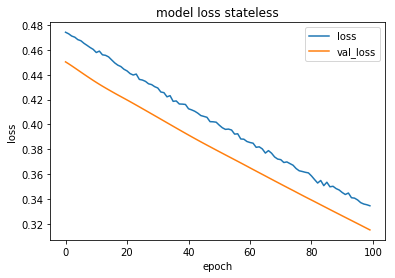

0.330734962072
Time fitting stateless: 4.796562433242798s
Fitting stateful model...
1/10 epoch
Train on 3181 samples, validate on 168 samples
Epoch 1/1
15s - loss: 0.0350 - val_loss: 0.0021
2/10 epoch
Train on 3181 samples, validate on 168 samples
Epoch 1/1
14s - loss: 0.0182 - val_loss: 0.0056
3/10 epoch
Train on 3181 samples, validate on 168 samples
Epoch 1/1
14s - loss: 0.0175 - val_loss: 0.0057
4/10 epoch
Train on 3181 samples, validate on 168 samples
Epoch 1/1
14s - loss: 0.0173 - val_loss: 0.0025
5/10 epoch
Train on 3181 samples, validate on 168 samples
Epoch 1/1
15s - loss: 0.0145 - val_loss: 0.0029
6/10 epoch
Train on 3181 samples, validate on 168 samples
Epoch 1/1
15s - loss: 0.0155 - val_loss: 0.0011
7/10 epoch
Train on 3181 samples, validate on 168 samples
Epoch 1/1
15s - loss: 0.0141 - val_loss: 0.0015
8/10 epoch
Train on 3181 samples, validate on 168 samples
Epoch 1/1
14s - loss: 0.0140 - val_loss: 8.4877e-04
9/10 epoch
Train on 3181 samples, validate on 168 samples
Epoch 

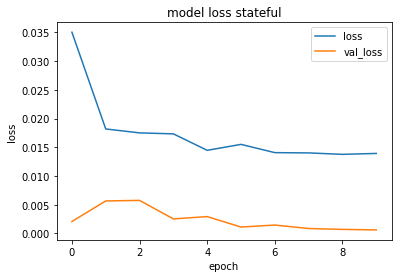

Time fitting stateless: 151.39939379692078s
Fitting jakobs model...
Train on 3181 samples, validate on 168 samples
Epoch 1/100
3181/3181 [==============================] - 2s - loss: 0.1568 - val_loss: 0.0030
Epoch 2/100
3181/3181 [==============================] - 0s - loss: 0.0061 - val_loss: 0.0021
Epoch 3/100
3181/3181 [==============================] - 0s - loss: 0.0061 - val_loss: 0.0027
Epoch 4/100
3181/3181 [==============================] - 0s - loss: 0.0060 - val_loss: 0.0021
Epoch 5/100
3181/3181 [==============================] - 0s - loss: 0.0061 - val_loss: 0.0022
Epoch 6/100
3181/3181 [==============================] - 0s - loss: 0.0060 - val_loss: 0.0021
Epoch 7/100
3181/3181 [==============================] - 0s - loss: 0.0060 - val_loss: 0.0024
Epoch 8/100
3181/3181 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0023
Epoch 9/100
3181/3181 [==============================] - 0s - loss: 0.0059 - val_loss: 0.0038
Epoch 10/100
3181/3181 [===============

3181/3181 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0030
Epoch 87/100
3181/3181 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0023
Epoch 88/100
3181/3181 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0026
Epoch 89/100
3181/3181 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0021
Epoch 90/100
3181/3181 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0023
Epoch 91/100
3181/3181 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0027
Epoch 92/100
3181/3181 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0022
Epoch 93/100
3181/3181 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0029
Epoch 94/100
3181/3181 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0021
Epoch 95/100
3181/3181 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0024
Epoch 96/100
3181/3181 [==============================] - 0s - 

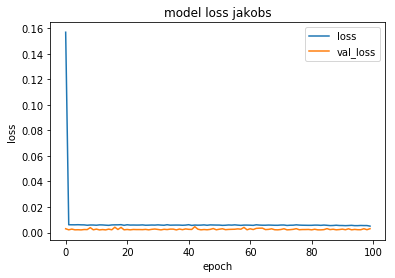

Time fitting jakob's: 91.40162134170532s


In [3]:
# def plot_results(predicted_data, true_data):
#     fig = plt.figure(facecolor='white')
#     ax = fig.add_subplot(111)
#     ax.plot(true_data, label='True Data')
#     plt.plot(predicted_data, label='Prediction')
#     plt.legend()
#     plt.show()
models = {}
# trainX = X_train
# trainY = y_train
# testX = X_test
# testY = y_test
for i in range(0,3):
    state = i
    if state == 0:
        print ("Fitting stateless model...")
        d0 = time.time()
        # 1. define network STATELESS
        model = Sequential()
        model.add(LSTM(10, input_shape=(1,1)))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        # 2. compile network
        model.compile(optimizer='adam', loss='mean_squared_error')
        # 3. fit network
        history = model.fit(trainX, trainY, epochs=100, batch_size=len(trainX), verbose=1,validation_split=0.05)
        # summarize history for loss
        plt.figure()
        plt.plot(history.history['loss'],label='loss')
        plt.plot(history.history['val_loss'],label='val_loss')
        plt.title('model loss stateless')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()
        # 4. evaluate network
        loss = model.evaluate(testX, testY, verbose=0)
        print(loss)
        models['stateless'] = model
        d1 = time.time()
        dt = d1-d0
        print ("Time fitting stateless: {}s".format(dt))
    elif state == 1:
        print ("Fitting stateful model...")
        epoch = 10
        d0 = time.time()
        # 1. define network STATEFUL
        batch_size = 1
        model = Sequential()
        model.add(LSTM(10,batch_input_shape=(batch_size, 1, 1), stateful=True))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        # 2. compile network
        model.compile(optimizer='adam', loss='mean_squared_error')
        # 3. fit network
        loss = []
        val_loss = []
        for i in range(epoch):
            print ("{}/{} epoch".format(i+1,epoch))
            history = model.fit(trainX, trainY, epochs=1, batch_size=batch_size,verbose=2,shuffle=False,validation_split=0.05)
            loss.append(history.history['loss'])
            val_loss.append(history.history['val_loss'])
            model.reset_states()
        # summarize history for loss
        plt.figure()
        plt.plot(loss,label='loss')
        plt.plot(val_loss,label='val_loss')
        plt.title('model loss stateful')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()
        models['stateful'] = model
        d1 = time.time()
        dt = d1-d0
        print ("Time fitting stateless: {}s".format(dt))
    elif state == 2:
        print ("Fitting jakobs model...")
        epoch = 100
#         trainX = X_train
#         trainY = y_train
        d0 = time.time()
        # Use jakobs model
        model = Sequential()
        # add hidden lstm with 50 neurons
        model.add(LSTM(
            50,
            input_shape = (1,1),
            return_sequences = True))
        model.add(Dropout(0.2))
        # add another lstm with 100 neurons
        model.add(LSTM(
            100,
            return_sequences=False))
        model.add(Dropout(0.2))
        # output to 1 neuron
        model.add(Dense(1))
        model.add(Activation("linear"))
        # compile model
        model.compile(loss='mse',optimizer='rmsprop')
        # fit model
        history = model.fit(trainX, trainY, batch_size=32, epochs=epoch, validation_split=0.05)
        # summarize history for loss
        plt.figure()
        plt.plot(history.history['loss'],label='loss')
        plt.plot(history.history['val_loss'],label='val_loss')
        plt.title('model loss jakobs')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()   
        # save to models
        models['jakob'] = model
        d1 = time.time()
        dt = d1-d0
        print ("Time fitting jakob's: {}s".format(dt))

In [ ]:
# # Try new data pred
# import numpy as np
# length = 50
# sequence = np.arange(0.999,1.01,0.001)
# X = sequence
# X = X.reshape(len(X), 1, 1)
# testX = testX[-50:]
# testY = testY[-50:]
history.history

Stateful prediction...
[[ 0.9999859]] 0.998346054 0.973712
RMSE: 0.02463414613638315


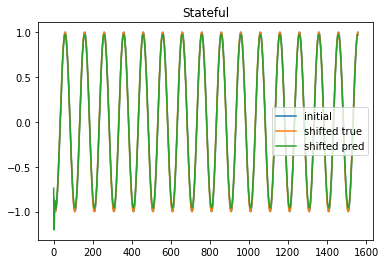

Jakob's prediction...
[[ 0.9999859]] 0.998346054 0.936543
RMSE: 0.06180348340902719


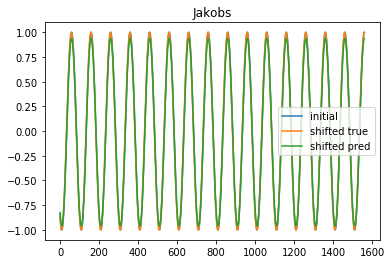

Stateless prediction...
[[ 0.9999859]] 0.998346054 0.170957
RMSE: 0.827389338058571


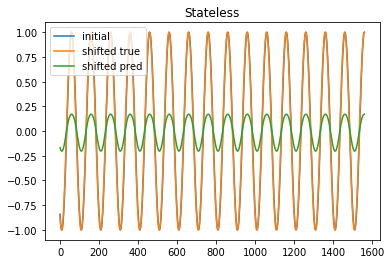

In [4]:
# 5. make predictions
from sklearn.metrics import mean_squared_error
from math import sqrt
for mod in models.keys():
    if mod == 'stateful':
        predictions = models[mod].predict(testX,batch_size=1, verbose=0)
        rmse = sqrt(mean_squared_error([testY[-1]],predictions[-1]))
        plt.figure(0)
        print ("Stateful prediction...")
        print (testX[-1],testY[-1],predictions[-1][0])
        print ("RMSE: {}".format(rmse))
        plt.title('Stateful')
        plt.plot(testX[:, 0],label='initial')
        plt.plot(testY,label='shifted true')
        plt.plot(predictions,label='shifted pred')
        plt.legend()
        plt.show()
    elif mod == 'stateless':
        predictions = models[mod].predict(testX, verbose=0)
        rmse = sqrt(mean_squared_error([testY[-1]],predictions[-1]))
        plt.figure(1)
        print ("Stateless prediction...")
        print (testX[-1],testY[-1],predictions[-1][0])
        print ("RMSE: {}".format(rmse))
        plt.title('Stateless')
        plt.plot(testX[:, 0],label='initial')
        plt.plot(testY,label='shifted true')
        plt.plot(predictions,label='shifted pred')
        plt.legend()
        plt.show()
    elif mod == 'jakob':
#         testX = X_test
#         testY = y_test
        predictions = models[mod].predict(testX)
#         predictions = np.reshape(predictions, (predictions.size,))
        rmse = sqrt(mean_squared_error([testY[-1]],predictions[-1]))
        plt.figure(3)
        print ("Jakob's prediction...")
        print (testX[-1],testY[-1],predictions[-1][0])
        print ("RMSE: {}".format(rmse))
        plt.title('Jakobs')
        plt.plot(testX[:, 0],label='initial')
        plt.plot(testY,label='shifted true')
        plt.plot(predictions,label='shifted pred')
        plt.legend()
        plt.show()
# stateful = True
# if stateful:
#     predictions = model.predict(X,batch_size=1, verbose=0)
# else:
#     predictions = model.predict(X, verbose=0)
# # print(predictions[:, 0][-10:])
# # predictions = predictions[-10:]
# print X[-1],y[-1],predictions[-1][0]
# plt.plot(X[:, 0])
# plt.plot(predictions)

Stateful prediction...
[[ 0.80588467]] 0.841470985 0.862188
RMSE: 0.1361580723944703


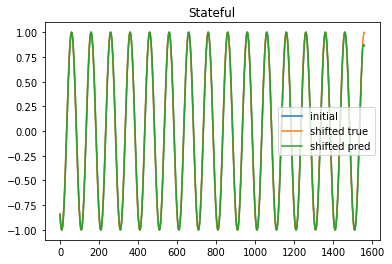

Stateless prediction...
[[ 0.80588467]] 0.841470985 0.013055
RMSE: 0.9852910796228448


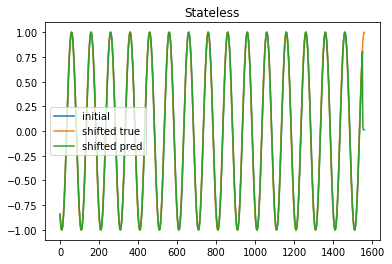

In [11]:
# 5. make predictions but shift forward n steps
from sklearn.metrics import mean_squared_error
from math import sqrt
n = 10
for mod in models.keys():
    if mod == 'stateful':
        predicted = shifttestX
        for i in range(n):
            predictions = models[mod].predict(predicted.reshape(len(predicted),1,1),batch_size=1, verbose=0)
            predicted = np.append(predicted,predictions[-1])
            rmse = sqrt(mean_squared_error([testY[-1]],predictions[-1]))
        plt.figure()
        print ("Stateful prediction...")
        print (shifttestX[-1],shifttestY[-1],predictions[-1][0])
        print ("RMSE: {}".format(rmse))
        plt.title('Stateful')
        plt.plot(shifttestX[:,0],label='initial')
        plt.plot(testY,label='shifted true')
        plt.plot(predicted,label='shifted pred')
        plt.legend()
        plt.show()
    elif mod == 'stateless':
        predicted = shifttestX
        for i in range(n):
            predictions = models[mod].predict(predicted.reshape(len(predicted),1,1), verbose=0)
            predicted = np.append(predicted,predictions[-1])
            rmse = sqrt(mean_squared_error([testY[-1]],predictions[-1]))
        plt.figure()
        print ("Stateless prediction...")
        print (shifttestX[-1],shifttestY[-1],predictions[-1][0])
        print ("RMSE: {}".format(rmse))
        plt.title('Stateless')
        plt.plot(shifttestX[:,0],label='initial')
        plt.plot(testY,label='shifted true')
        plt.plot(predicted,label='shifted pred')
        plt.legend()
        plt.show()
    elif mod == 'jakob':
        predicted = shifttestX
        # testX = X_test
        # testY = y_test
        for i in range(n):
            predictions = models[mod].predict(predicted.reshape(len(predicted),1,1))
#             print predictions[-1]
            predicted = np.append(predicted,predictions[-1])
            rmse = sqrt(mean_squared_error([testY[-1]],predictions[-1]))
        plt.figure()
        print ("Jakob's prediction...")
        print (len(predicted))
        print (shifttestX[-1],shifttestY[-1],predictions[-1][0])
        print ("RMSE: {}".format(rmse))
        plt.title('Jakobs')
        plt.plot(shifttestX[:,0],label='initial')
        plt.plot(testY,label='shifted true')
        plt.plot(predicted,label='shifted pred')
        plt.legend()
        plt.show()

In [59]:
X = np.array(0.80588467).reshape(1,1,1)
p = models['jakob'].predict(X)
print p
print X

[[ 0.81853259]]
[[[ 0.80588467]]]


Stateful prediction...50
[[ 0.80588467]] 0.841470985 0.828496
RMSE: 0.0129754229234
Stateless prediction...10
[[ 0.80588467]] 0.841470985 0.782955
RMSE: 0.0585164113687

In [ ]:
testX[:,0]

In [ ]:
plt.plot(testY,label='shifted pred')

In [ ]:
from keras.utils import plot_model
plot_model(models['stateful'], to_file='model_stateful.png',show_shapes=True)

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(models['stateful']).create(prog='dot', format='svg'))